##### top

# Estimate shrinking of variance for high reliabilities due to contrains of the data


As it was observed in Figure 3 of the paper, the standard deviation of the possible correlations (the width of the distribution of the correlations) is shrinking with increasing reliability. This effect can be a pure artefact of the fact that the dataset that is sampled is also smaller as the number of trials sampled from it increases -- the variance will be artifically lower just because of the extent of sampling. This ntb tests if this is the reason for the shrinkage by implementing constraints on the dataset for each reliability level. As can be seen, there are two effects and none can be explained by the proposed artefact. One is that the standard deviation of hte distribution of correlations reduces with increased reliabily (on the x-axis). The other is that it also reduces with the level of contrains we put on the dataset (colour).

* [Run repeating simulations on a much larger dataset](#Run-repeating-simulations-on-a-much-larger-dataset)
* [Plot it for the paper](#Plot-it-for-the-paper)

In [1]:
import os, sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lmfit import Model

# Define path and name
user = "jan"

if user == "jan":
    csv_raw_data_path = "../Data/raw_CSV"
    csv_raw_pilot_data_path = "../Data/raw_CSV/piloting"
    path_demo = '../Data/demographic_data/'

    csv_clean_data_path = "../Data/cleaned_CSV" 
    
    path_results = "../Data/results" 
    path_curve_fit = os.path.join(path_results, "curve_fits")
    path_meaning = os.path.join(path_results, "reliability_meaning")
    
    # Importing module for functions
    functions_modul =  "./functions"
    sys.path.insert(0, functions_modul)
    
# import all processing and plotting functions
from reliability_functions import bin_samples_rand4, hyperbolic_fit, run_reliability_estimate4many_trials#, take_sample_df


# define the data
num_forms = 2 # to reproduce exactly what we had now
n_trials_per_form_MST = 320
n_trials_per_form_PIM_MC = 24*4 # it's MC and combines the 4


# load the real means
df_means = pd.read_csv(os.path.join(path_meaning, f'PIM_MC-MST_accuracy.csv'))
N = df_means["userID"].unique().size
print(f"Correlation in the data: {df_means.corr().iloc[0,1]}")

# generate data with the given statistics
rng_data = np.random.default_rng(287) # 220
PIM_array = bin_samples_rand4(rng_data, N, num_forms*n_trials_per_form_PIM_MC, df_means["correct_PIM_MC"].values, ravel=False)
MST_array = bin_samples_rand4(rng_data, N, num_forms*n_trials_per_form_MST, df_means["correct_MST"].values, ravel=False)
print(f"Correlation in simulated data: {np.corrcoef(PIM_array.mean(axis=1), MST_array.mean(axis=1))[0,1]}")
print(f"Are correlations close: {np.isclose(df_means.corr().iloc[0,1], np.corrcoef(PIM_array.mean(axis=1), MST_array.mean(axis=1))[0,1], atol=10**-3)}")
print(f"N={N}")

Correlation in the data: 0.15607680515167086
Correlation in simulated data: 0.1383253511112781
Are correlations close: False
N=75


In [2]:
# calculate reliability curves

corr_array, trial_time, n_trials_list = None, None, None

# how many samples we want to correlate
n_repeats = 10**3

# define df
df_PIM = pd.DataFrame({
         'userID': np.repeat(np.arange(N), num_forms*n_trials_per_form_PIM_MC),
         'correct': PIM_array.ravel(),
     })

df_MST = pd.DataFrame({
         'userID': np.repeat(np.arange(N), num_forms*n_trials_per_form_MST),
         'correct': MST_array.ravel(),
     })

# run the simulation
corr_array_PIM, _, n_trials_list_PIM = run_reliability_estimate4many_trials(num_forms*n_trials_per_form_PIM_MC, 
                                                                            df_PIM, 
                                                                             N, '', save=False,
                                                                             n_repeats=n_repeats, num_forms=num_forms,
                                                                             path_curve_fit=path_curve_fit)


# run the simulation
corr_array_MST, _, n_trials_list_MST = run_reliability_estimate4many_trials(num_forms*n_trials_per_form_MST, 
                                                                            df_MST, 
                                                                             N, '', save=False,
                                                                             n_repeats=n_repeats, num_forms=num_forms,
                                                                             path_curve_fit=path_curve_fit)


Going over (5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95) trials per task, ie. 19 items
Time per 5 trials: 2.30 s which is 0.04 min.
Time per 10 trials: 2.23 s which is 0.04 min.
Time per 15 trials: 2.40 s which is 0.04 min.
Time per 20 trials: 2.23 s which is 0.04 min.
Time per 25 trials: 2.28 s which is 0.04 min.
Time per 30 trials: 2.26 s which is 0.04 min.
Time per 35 trials: 2.23 s which is 0.04 min.
Time per 40 trials: 2.32 s which is 0.04 min.
Time per 45 trials: 2.20 s which is 0.04 min.
Time per 50 trials: 2.35 s which is 0.04 min.
Time per 55 trials: 2.35 s which is 0.04 min.
Time per 60 trials: 2.43 s which is 0.04 min.
Time per 65 trials: 2.42 s which is 0.04 min.
Time per 70 trials: 2.53 s which is 0.04 min.
Time per 75 trials: 2.53 s which is 0.04 min.
Time per 80 trials: 2.57 s which is 0.04 min.
Time per 85 trials: 2.54 s which is 0.04 min.
Time per 90 trials: 2.54 s which is 0.04 min.
Time per 95 trials: 2.75 s which is 0.05 min.
Process to

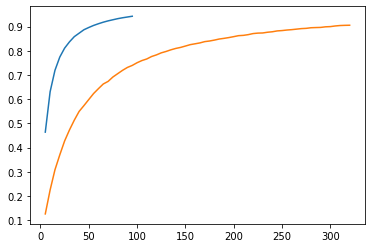

In [3]:
# check
plt.plot(n_trials_list_PIM, corr_array_PIM.mean(axis=1))
plt.plot(n_trials_list_MST, corr_array_MST.mean(axis=1))
plt.show()

In [4]:
# fit reliability
# define where to save
df_results_tasks_hyperbolic = pd.DataFrame(columns=["task", "model_name", "bic", "aic", "chi_sq"])

dic_results_tasks_hyperbolic = {}


for task in ["PIM", "MST"]:

    y = eval(f"corr_array_{task}").mean(axis=1)
    x = eval(f"n_trials_list_{task}")

    # go over all the functions
    for (i,fx) in enumerate([hyperbolic_fit]):

        result = None
        gmodel = None
        
        # initiate the model
        gmodel = Model(fx, nan_policy='omit')

        # set params, it differs for different functions
        if len(gmodel.param_names)==1:
            params = gmodel.make_params(a=0.3)
            print(f"For model {gmodel.name} taking 1 param.")        

        else:
            print("wrong model")
            exit()

        # perform the fit
        try:
            result = gmodel.fit(y, params, x=x)
                    # save summary
            df_results_tasks_hyperbolic = df_results_tasks_hyperbolic.append(
                pd.DataFrame({
                    "task": [task],
                    "model_name": [result.model.name],
                    "bic": [result.bic],
                    "aic": [result.aic],
                    "chi_sq": [result.chisqr],
                    "a": [result.best_values["a"]],
#                     "sigma": [result.best_values["sigma"]],
                    "n_trials": [x.max()],
                    })
            )
            
            
        except ValueError:
            result = None
            # save summary
            df_results_tasks_hyperbolic = df_results_tasks_hyperbolic.append(
                pd.DataFrame({
                    "task": [task],
                    "model_name": [gmodel.name],
                    "bic": [None],
                    "aic": [None],
                    "chi_sq": [None],
#                     "mu": [result.best_values["mu"]],
#                     "sigma": [result.best_values["sigma"]],
                    })
            )

        # save results
        dic_results_tasks_hyperbolic[str(gmodel.name)+'--'+str(task)] = result
        

# define how many trials we shall need to get to certail reliability
df_needed_trials = pd.DataFrame()

reliabilities = np.arange(0.2, 1, 0.05)

for row in df_results_tasks_hyperbolic[df_results_tasks_hyperbolic["model_name"]=='Model(hyperbolic_fit)'].iterrows():
    for thr in reliabilities:
        
        df_needed_trials = df_needed_trials.append(pd.DataFrame({
            'task': row[1]["task"],
            'fit': ['hyperbolic'],
            'thr': [thr],
            'trials needed': int(np.round((thr*row[1]["a"])/(1-thr))),
        }))        
        
df_needed_trials  

For model Model(hyperbolic_fit) taking 1 param.
For model Model(hyperbolic_fit) taking 1 param.


,task,fit,thr,trials needed
0,PIM,hyperbolic,0.20,1
0,PIM,hyperbolic,0.25,2
0,PIM,hyperbolic,0.30,2
0,PIM,hyperbolic,0.35,3
0,PIM,hyperbolic,0.40,4
0,PIM,hyperbolic,0.45,5
0,PIM,hyperbolic,0.50,6
0,PIM,hyperbolic,0.55,7
0,PIM,hyperbolic,0.60,9
0,PIM,hyperbolic,0.65,11


## Run repeating simulations on a much larger dataset

[top](#top)

Assumption:

the reliability of the smaller dataset will be the same as the reliability of the bigger -> I do not need to recreate the RL curves and fit them again, I can use what I know from up until now.

In [5]:
# define the data
num_forms = 10 # to have enough trials
n_trials_per_form_MST = 320
n_trials_per_form_PIM_MC = 24*4 # it's MC and combines the 4


print(f"Correlation in the data: {df_means.corr().iloc[0,1]}")

# generate data with the given statistics
rng_data = np.random.default_rng(287)
PIM_array_big = bin_samples_rand4(rng_data, N, num_forms*n_trials_per_form_PIM_MC, df_means["correct_PIM_MC"].values, ravel=False)
MST_array_big = bin_samples_rand4(rng_data, N, num_forms*n_trials_per_form_MST, df_means["correct_MST"].values, ravel=False)
print(f"Correlation in simulated data: {np.corrcoef(PIM_array_big.mean(axis=1), MST_array_big.mean(axis=1))[0,1]}")
print(f"Are correlations close: {np.isclose(df_means.corr().iloc[0,1], np.corrcoef(PIM_array_big.mean(axis=1), MST_array_big.mean(axis=1))[0,1], atol=10**-3)}")


Correlation in the data: 0.15607680515167086
Correlation in simulated data: 0.15430776710824276
Are correlations close: False


In [6]:
# define for all three conditions

# how many times sample and correlate
n_corr_repeats = 10**3

# how many simulations
n_simulations = 10**2

# up to which reliability
rel_thr = 0.9

In [7]:
start = time.time()

# what percentage to sample
L_const = 1/0.8 # 80% of the dataset

# # how many times sample and correlate
# n_corr_repeats = 10**3

# # how many simulations
# n_simulations = 10**1

# # up to which reliability
# rel_thr = 0.9

corr_distribution_array_constrained_big = np.zeros((n_simulations, len(reliabilities[reliabilities<rel_thr]), n_corr_repeats))
print(f"Taking {corr_distribution_array_constrained_big.shape[0]} simulations {corr_distribution_array_constrained_big.shape[1]} thresholds and {corr_distribution_array_constrained_big.shape[2]} iterations.")

for s in range(n_simulations):

    for j, thr in enumerate(reliabilities[reliabilities<rel_thr]):
        n_pim_mc = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="PIM"), "trials needed"].values[0]
        n_mst    = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="MST"), "trials needed"].values[0]
        if s==0:
            print(f'For {thr:.2f} needed pim: {n_pim_mc}, needed mst: {n_mst}')

        # define size of restricted dataset
        r1_size = np.ceil(n_pim_mc*L_const).astype(int)
        r2_size = np.ceil(n_mst*L_const).astype(int)
        if s==0:
            print(f'Percentage of the unconstrained dataset: \n{n_pim_mc/r1_size:.3f} and {n_mst/r2_size:.3f}\n')

        # define restricted dataset
        rng_restricted = np.random.default_rng(j+s)
        df_r1 = rng_restricted.choice(PIM_array_big, size=r1_size, replace=False, axis=1)
        df_r2 = rng_restricted.choice(MST_array_big, size=r2_size, replace=False, axis=1)

        # sample several times
        for i in range(n_corr_repeats):
            # define state
            rng_choice = np.random.default_rng(i+j+s)

            # save correlation
            corr_distribution_array_constrained_big[s,j,i] = np.corrcoef(
                rng_choice.choice(df_r1, size=n_pim_mc, replace=False, axis=1).mean(axis=1), 
                rng_choice.choice(df_r2, size=n_mst, replace=False, axis=1).mean(axis=1))[0,1]

        
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.")
# 6 mins per 100 sim

Taking 100 simulations 15 thresholds and 1000 iterations.
For 0.20 needed pim: 1, needed mst: 8
Percentage of the unconstrained dataset: 
0.500 and 0.800

For 0.25 needed pim: 2, needed mst: 11
Percentage of the unconstrained dataset: 
0.667 and 0.786

For 0.30 needed pim: 2, needed mst: 14
Percentage of the unconstrained dataset: 
0.667 and 0.778

For 0.35 needed pim: 3, needed mst: 18
Percentage of the unconstrained dataset: 
0.750 and 0.783

For 0.40 needed pim: 4, needed mst: 22
Percentage of the unconstrained dataset: 
0.800 and 0.786

For 0.45 needed pim: 5, needed mst: 27
Percentage of the unconstrained dataset: 
0.714 and 0.794

For 0.50 needed pim: 6, needed mst: 33
Percentage of the unconstrained dataset: 
0.750 and 0.786

For 0.55 needed pim: 7, needed mst: 41
Percentage of the unconstrained dataset: 
0.778 and 0.788

For 0.60 needed pim: 9, needed mst: 50
Percentage of the unconstrained dataset: 
0.750 and 0.794

For 0.65 needed pim: 11, needed mst: 62
Percentage of the unc

In [8]:
start = time.time()

# what percentage to sample
L_const = 2 # 50% of the dataset

# # how many times sample and correlate
# n_corr_repeats = 10**3

# # how many simulations
# n_simulations = 10**2

# # up to which reliability
# rel_thr = 0.9

corr_distribution_array_unconstrained_big = np.zeros((n_simulations, len(reliabilities[reliabilities<rel_thr]), n_corr_repeats))
print(f"Taking {corr_distribution_array_unconstrained_big.shape[0]} simulations {corr_distribution_array_unconstrained_big.shape[1]} thresholds and {corr_distribution_array_unconstrained_big.shape[2]} iterations.")

for s in range(n_simulations):

    for j, thr in enumerate(reliabilities[reliabilities<rel_thr]):
        n_pim_mc = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="PIM"), "trials needed"].values[0]
        n_mst    = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="MST"), "trials needed"].values[0]
        if s==0:
            print(f'For {thr:.2f} needed pim: {n_pim_mc}, needed mst: {n_mst}')

        # define size of restricted dataset
        r1_size = np.ceil(n_pim_mc*L_const).astype(int)
        r2_size = np.ceil(n_mst*L_const).astype(int)
        if s==0:
            print(f'Percentage of the ununconstrained dataset: \n{n_pim_mc/r1_size:.3f} and {n_mst/r2_size:.3f}\n')

        # define restricted dataset
        rng_restricted = np.random.default_rng(j+s)
        df_r1 = rng_restricted.choice(PIM_array_big, size=r1_size, replace=False, axis=1)
        df_r2 = rng_restricted.choice(MST_array_big, size=r2_size, replace=False, axis=1)

        # sample several times
        for i in range(n_corr_repeats):
            # define state
            rng_choice = np.random.default_rng(i+j+s)

            # save correlation
            corr_distribution_array_unconstrained_big[s,j,i] = np.corrcoef(
                rng_choice.choice(df_r1, size=n_pim_mc, replace=False, axis=1).mean(axis=1), 
                rng_choice.choice(df_r2, size=n_mst, replace=False, axis=1).mean(axis=1))[0,1]

        
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.")
# 357 s which is 5.9 min


Taking 100 simulations 15 thresholds and 1000 iterations.
For 0.20 needed pim: 1, needed mst: 8
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.25 needed pim: 2, needed mst: 11
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.30 needed pim: 2, needed mst: 14
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.35 needed pim: 3, needed mst: 18
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.40 needed pim: 4, needed mst: 22
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.45 needed pim: 5, needed mst: 27
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.50 needed pim: 6, needed mst: 33
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.55 needed pim: 7, needed mst: 41
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.60 needed pim: 9, needed mst: 50
Percentage of the ununconstrained dataset: 
0.500 and 0.500

For 0.65 needed pim: 11, needed mst: 62
Per

In [9]:
start = time.time()

# what percentage to sample
L_const = 1/0.2 # 20% of the dataset

# # how many times sample and correlate
# n_corr_repeats = 10**3

# # how many simulations
# n_simulations = 10**1

# # up to which reliability
# rel_thr = 0.9

corr_distribution_array_unconstrained_02_big = np.zeros((n_simulations, len(reliabilities[reliabilities<rel_thr]), n_corr_repeats))
print(f"Taking {corr_distribution_array_unconstrained_02_big.shape[0]} simulations {corr_distribution_array_unconstrained_02_big.shape[1]} thresholds and {corr_distribution_array_unconstrained_02_big.shape[2]} iterations.")

for s in range(n_simulations):

    for j, thr in enumerate(reliabilities[reliabilities<rel_thr]):
        n_pim_mc = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="PIM"), "trials needed"].values[0]
        n_mst    = df_needed_trials.loc[(df_needed_trials["thr"]==thr)&(df_needed_trials["task"]=="MST"), "trials needed"].values[0]
        if s==0:
            print(f'For {thr:.2f} needed pim: {n_pim_mc}, needed mst: {n_mst}')

        # define size of restricted dataset
        r1_size = np.ceil(n_pim_mc*L_const).astype(int)
        r2_size = np.ceil(n_mst*L_const).astype(int)
        if s==0:
            print(f'Percentage of the ununconstrained dataset: \n{n_pim_mc/r1_size:.3f} and {n_mst/r2_size:.3f}\n')

        # define restricted dataset
        rng_restricted = np.random.default_rng(j+s)
        df_r1 = rng_restricted.choice(PIM_array_big, size=r1_size, replace=False, axis=1)
        df_r2 = rng_restricted.choice(MST_array_big, size=r2_size, replace=False, axis=1)

        # sample several times
        for i in range(n_corr_repeats):
            # define state
            rng_choice = np.random.default_rng(i+j+s)

            # save correlation
            corr_distribution_array_unconstrained_02_big[s,j,i] = np.corrcoef(
                rng_choice.choice(df_r1, size=n_pim_mc, replace=False, axis=1).mean(axis=1), 
                rng_choice.choice(df_r2, size=n_mst, replace=False, axis=1).mean(axis=1))[0,1]

        
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.")
# 340 s which is 5.7 min

Taking 100 simulations 15 thresholds and 1000 iterations.
For 0.20 needed pim: 1, needed mst: 8
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.25 needed pim: 2, needed mst: 11
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.30 needed pim: 2, needed mst: 14
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.35 needed pim: 3, needed mst: 18
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.40 needed pim: 4, needed mst: 22
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.45 needed pim: 5, needed mst: 27
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.50 needed pim: 6, needed mst: 33
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.55 needed pim: 7, needed mst: 41
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.60 needed pim: 9, needed mst: 50
Percentage of the ununconstrained dataset: 
0.200 and 0.200

For 0.65 needed pim: 11, needed mst: 62
Per

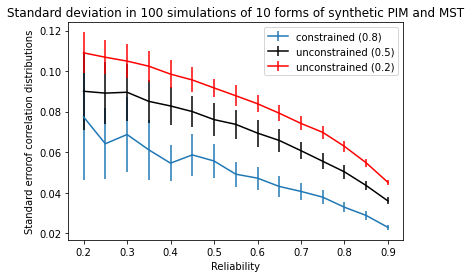

In [10]:
# plt.scatter(reliabilities[reliabilities<rel_thr], corr_distribution_array_constrained_big.std(axis=1), label='constrained')
# plt.scatter(reliabilities[reliabilities<rel_thr], corr_distribution_array_unconstrained_big.std(axis=1), c='k', label='unconstrained')


# plt.scatter(reliabilities[reliabilities<rel_thr], corr_distribution_array_constrained_big.std(axis=2).mean(axis=0), label='constrained')
# plt.scatter(reliabilities[reliabilities<rel_thr], corr_distribution_array_unconstrained_big.std(axis=2).mean(axis=0), c='k', label='unconstrained')

plt.errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_constrained_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_constrained_big.std(axis=2).std(axis=0), label='constrained (0.8)')
plt.errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_unconstrained_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_unconstrained_big.std(axis=2).std(axis=0), c='k', label='unconstrained (0.5)')

plt.errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_unconstrained_02_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_unconstrained_02_big.std(axis=2).std(axis=0), c='r', label='unconstrained (0.2)')



plt.xlabel('Reliability')
plt.ylabel('Standard errorof correlation distributions')
plt.legend()


plt.title(f'Standard deviation in {n_simulations} simulations of {num_forms} forms of synthetic PIM and MST')
plt.show()

### Plot it for the paper
[top](#top)

{'name': 'Arial'}
Standard deviation in 100 simulations of 10 forms of synthetic PIM and MST


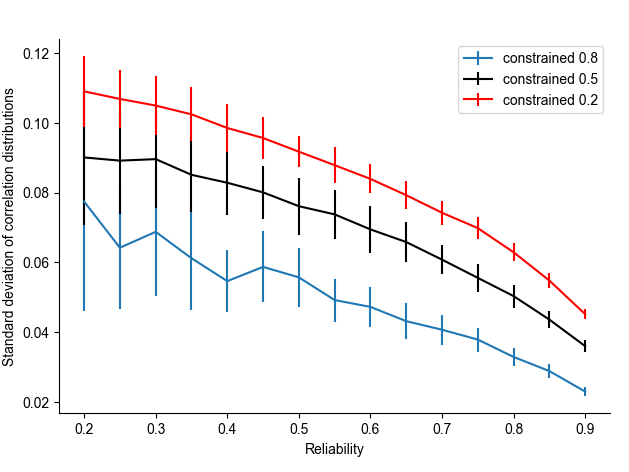

In [11]:
path_figures = '../Figures'

#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 16#20
b = 12
# rot = 15
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10, ticksize=legend_size)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
# c.add_text("A)", Point(.02, 0.98), weight="bold", size=font_size)
# c.add_text("B)", Point(.02, 0.32), weight="bold", size=font_size)
           
# titles
titles = [f'Standard deviation in {n_simulations} simulations of {num_forms} forms of synthetic PIM and MST']
# c.add_text(titles[0], Point(.5, 0.96), size=font_size)
# c.add_text(titles[1], Point(.5, 0.32), size=font_size)
# c.add_text(titles[2], Point(.47, 0.5), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.
bottom_offset = 1.5
right_offset = 1.5
hsb = 2 #half_space_between - horizontal
vsb = 1.5 #half_space_between - vertical

# add a 1x1 grid
c.add_grid(["shrink"], 1, Point(right_offset, bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")


######### panel A
c.ax("shrink").errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_constrained_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_constrained_big.std(axis=2).std(axis=0), label='constrained 0.8')
c.ax("shrink").errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_unconstrained_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_unconstrained_big.std(axis=2).std(axis=0), c='k', label='constrained 0.5')

c.ax("shrink").errorbar(reliabilities[reliabilities<rel_thr], 
             corr_distribution_array_unconstrained_02_big.std(axis=2).mean(axis=0), 
             yerr=corr_distribution_array_unconstrained_02_big.std(axis=2).std(axis=0), c='r', label='constrained 0.2')



c.ax("shrink").set_xlabel('Reliability')
c.ax("shrink").set_ylabel('Standard deviation of correlation distributions')
c.ax("shrink").legend()
# despine
sns.despine(ax=c.ax("shrink"))
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "SI", 'SI_Figure_6.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "SI", 'SI_Figure_6.pdf'), dpi=300)#, bbox_inches="tight")

In [12]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Mon Jul 03 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

seaborn   : 0.11.1
pandas    : 1.2.4
numpy     : 1.19.1
matplotlib: 3.6.2
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]



[top](#top)